In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import posterior_loss
from pyro.contrib.util import lexpand, rexpand

import matplotlib.pyplot as plt
import seaborn as sns

from nflows.transforms import made as made_module
import neural_nets
import flows
import pyro_flows

from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0waCDM, LambdaCDM, FlatLambdaCDM
from astropy import constants


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [81]:
np_dtype = np.float64
redshifts = np.arange(0, 5, 0.1, dtype=np_dtype)
designs = torch.tensor(redshifts).to(device).unsqueeze(-1)
designs[0:5]

tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000]], device='cuda:0')

In [77]:
def model_func(om, z):
    return 30.21/torch.sqrt(om*(1+z)**3+(1-om))

In [113]:
class likelihood_dist(dist.Distribution):
    def __init__(self, om, z, y_1, y_2, sig_0, sig_1, sig_2):
        self.om = om
        self.z = z
        self.y_1 = y_1
        self.y_2 = y_2
        self.sig_0 = sig_0
        self.sig_1 = sig_1
        self.sig_2 = sig_2
        super().__init__()

    def sample(self, sample_shape=torch.Size([])):
        # sample from a gaussian centered on model prediction with std sigma
        samples = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).sample(sample_shape)
        return samples

    def log_prob(self, value):
        prob_y_0 = dist.Normal(model_func(self.om, self.z[...,0]), self.sig_0).log_prob(value)
        prob_y_1 = dist.Normal(model_func(self.om, self.z[...,1]), self.sig_1).log_prob(self.y_1)
        prob_y_2 = dist.Normal(model_func(self.om, self.z[...,2]), self.sig_2).log_prob(self.y_2)
        log_prob = prob_y_0+prob_y_1+prob_y_2
        return log_prob


In [84]:
class bed_cosmology:

    def __init__(self, cosmo, priors, sigma_y):
        self.cosmo = cosmo
        self.sigma_y = sigma_y
        self.r_drag = 147.55
        self.coeff = torch.tensor(constants.c.to('km/s').value/(self.cosmo.H0.value*self.r_drag), device=device)
        self.priors = priors
    
    def D_H_func(self, z, Om, Ode, Orad=None, w0=None, wa=None):
        if self.cosmo.name == 'FlatLambdaCDM':
            return self.coeff/torch.sqrt(Om * (1+z)**3 + (1-Om-Ode) * (1+z)**4 + Ode)

        elif self.cosmo.name == 'LambdaCDM':
            if Orad is None:
                raise ValueError("Orad is required for LambdaCDM")
            return self.coeff/torch.sqrt(Om * (1+z)**3 + Orad * (1+z)**4 + Ode + (1-Om-Orad-Ode) * (1+z)**2)

        elif self.cosmo.name == 'w0waCDM':
            if Orad is None or w0 is None or wa is None:
                raise ValueError("Orad, w0, and wa are required for w0waCDM")
            return self.coeff/torch.sqrt(Om * (1+z)**3 + Orad * (1+z)**4 + Ode * (1+z)**(3*(1+(w0+wa*z/(1+z)))) + (1-Om-Orad-Ode) * (1+z)**2)
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")
    
    def likelihood(self, params, features, designs):
        with GridStack(features, designs, params):
            # create a dictionary of the parameters
            kwargs = { }
            for key in params.names:
                kwargs[key] = getattr(params, key)
                
            y_mean = self.D_H_func(designs.z, **kwargs)
            y_diff = features.D_H - y_mean
            likelihood = np.exp(-0.5 * (y_diff / self.sigma_y) ** 2) 
            likelihood += 1e-10 # to avoid division by zero
            features.normalize(likelihood)
        return likelihood, y_mean
    
    def pyro_model(self, z):
        with pyro.plate_stack("plate", z.shape[:-1]):
            kwargs = {}
            for i, (k, v) in enumerate(self.priors.items()):
                if isinstance(v, dist.Distribution):
                    kwargs[k] = pyro.sample(k, v).unsqueeze(-1)
                else:
                    kwargs[k] = v
            mean = self.D_H_func(z, **kwargs)
            # check for nan values in mean
            if torch.isnan(mean).any():
                print(f'Nan values in mean: {mean}')
                print(f'Parameters: {kwargs}')
            return pyro.sample("y", dist.Normal(mean, self.sigma_y).to_event(1))

In [ ]:
Om_range = torch.tensor([0.2, 0.4], device=device)

In [85]:
Om_range = torch.tensor([0.2, 0.4], device=device)
Ode_range = torch.tensor([0.6, 0.8], device=device)
w0_range = torch.tensor([-3.0, 1.0], device=device)
wa_range = torch.tensor([-3.0, 2.0], device=device)
cosmologies = ['FlatLambdaCDM']

for c in cosmologies:
    if c == 'LambdaCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range), 'Orad': torch.tensor(0.00149, device=device)}
        bed_cosmo = bed_cosmology(
            cosmo=LambdaCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, Neff=Planck18.Neff, m_nu=Planck18.m_nu, name='LambdaCDM'), 
            priors=priors, 
            sigma_y=0.1)
    elif c == 'FlatLambdaCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range)}
        bed_cosmo = bed_cosmology(
            cosmo=FlatLambdaCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, name='FlatLambdaCDM'), 
            priors=priors, 
            sigma_y=0.1)
    elif c == 'w0waCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range), 'Orad': torch.tensor(0.00149, device=device), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}
        bed_cosmo = bed_cosmology(
            cosmo=w0waCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, Neff=Planck18.Neff, m_nu=Planck18.m_nu, name='w0waCDM'), 
            priors=priors, 
            sigma_y=0.1)

In [58]:
list(priors.keys()).remove('Orad')# remove Orad

In [99]:
om_prior = torch.tensor(0.315, device=device) # Gaussian prior mean
sigma_prior = torch.tensor(0.007, device=device) # Gaussian prior std
sig_0 = torch.tensor(0.2, device=device) # Gaussian likelihood std
# y_1 = torch.tensor(19.770, device=device) # LRG measurements mean
# sig_1 = torch.tensor(0.47, device=device) # LRG measurements std
# y_2 = torch.tensor(8.99, device=device) # Lyman-alpha measurements mean
# sig_2 = torch.tensor(0.19, device=device) # Lyman-alpha measurements std

def model(z):
    with pyro.plate_stack("plate", z.shape[:-1]):
        om = pyro.sample("om", dist.Normal(om_prior,sigma_prior)).unsqueeze(-1) # shape: [n,num_designs,1]
        mean = model_func(om, z)
        return pyro.sample("y", dist.Normal(mean, sig_0).to_event(1))

In [87]:
context_size = 2 # number of context/conditioning variables (design variables + observations)
posterior_dims = 1 # num of parameters in posterior distribution

num_blocks = 3 # number of blocks in the flow
num_transforms = 3 # number of transformations
hidden_features = 32 # number of hidden features in the flow

hyper_nn_args = {"context_features": context_size,
                "hidden_features": hidden_features,
                "num_blocks": num_blocks,
                "activation": torch.nn.ReLU(),
                "use_residual_blocks": False,
                "random_mask": False} # use a random mask for the MADE network
base_nn_args = {"type": "dense",
                "context_size": context_size,
                "hidden_dims": num_blocks*[hidden_features],
                "n_params": posterior_dims + posterior_dims + int(posterior_dims*(posterior_dims-1)/2), # number of parameters to output (65 for posterior_dim = 10)
                "nonlinearity": torch.nn.ReLU()}
flow_args = {"n_dims": posterior_dims, 
            "n_transforms": num_transforms, # number of transforms in the flow
            "hyper_type": "conditional_dense", # type of transformation network
            "hyper_args": hyper_nn_args, # arguments for transformation network
            "base_type": "conditional_normal", # type of base distribution
            "base_args": base_nn_args} # arguments for the base distribution

In [86]:
target_labels = list(priors.keys())
if 'Orad' in target_labels:
    target_labels.remove('Orad')
train_args = {"observation_labels": ["y"],
            "target_labels": target_labels,
            "model": bed_cosmo.pyro_model,
            "steps": 20000,
            "n_particles": 101,
            "train_verbose": False, 
            "condition_design": True,
            "device": device}

pyro.clear_param_store()
segments = 15
n_transforms = 15
input_dim = 4
context_dim = 2
learning_rate = 1e-3
posterior_flow, transforms = pyro_flows.spline_flow(n_transforms, input_dim, context_dim, segments, device)
modules = torch.nn.ModuleList(transforms)
optimizer = torch.optim.Adam(modules.parameters(), lr=learning_rate)

#posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)
#optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-4)
device = train_args["device"]
#posterior_flow.to(device)
#posterior_flow.train(mode=True)
pyro.set_rng_seed(0)
verbose_shapes = True
history = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_steps = [1000, 5000, 10000, 20000]
for step in range(train_args["steps"]):
    optimizer.zero_grad()
    agg_loss, loss = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=train_args["n_particles"],
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=False,
                                    nflow=True,
                                    condition_design=train_args["condition_design"],
                                    verbose_shapes=verbose_shapes)
    agg_loss.backward()
    optimizer.step()
    if step == 0:
        verbose_shapes = False
    if step in plot_steps:
        with torch.no_grad():
            agg_loss, eigs = posterior_loss(design=designs,
                                            model=train_args["model"],
                                            guide = posterior_flow,
                                            num_particles=50000,
                                            observation_labels=train_args["observation_labels"],
                                            target_labels=train_args["target_labels"],
                                            evaluation=True,
                                            nflow=True,
                                            condition_design=train_args["condition_design"])

        ax2.plot(redshifts, eigs.cpu().detach().numpy(), label=f'step {step}')
    history.append(loss)
    if train_args["train_verbose"] and (step % 250 == 0):
        print('step: {}, loss: {}'.format(step, agg_loss.item()))

stacked_history = torch.stack(history)
history_array = stacked_history.cpu().detach().numpy()
ax1.plot(history_array.sum(axis=1)/history_array.shape[-1])
with torch.no_grad():
    agg_loss, eigs = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=50000,
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=True,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])

ax2.plot(redshifts, eigs.cpu().detach().numpy(), label=f'step {train_args["steps"]}')
ax2.set_xlabel("Redshift of Observation")
ax2.set_ylabel("EIG")
ax2.legend()
plt.show()

Nan values in mean: tensor([[[30.0296],
         [29.2357],
         [26.5217],
         ...,
         [    nan],
         [    nan],
         [    nan]],

        [[30.0296],
         [28.1069],
         [27.5432],
         ...,
         [ 3.1204],
         [    nan],
         [    nan]],

        [[30.0296],
         [29.3882],
         [26.0635],
         ...,
         [ 2.7539],
         [    nan],
         [ 3.1263]],

        ...,

        [[30.0296],
         [29.1565],
         [27.4513],
         ...,
         [    nan],
         [ 5.8331],
         [    nan]],

        [[30.0296],
         [28.7763],
         [26.5814],
         ...,
         [ 6.6878],
         [ 3.8411],
         [    nan]],

        [[30.0296],
         [28.3405],
         [28.0489],
         ...,
         [ 3.3023],
         [ 2.2441],
         [    nan]]], device='cuda:0')
Parameters: {'Om': tensor([[[0.3761],
         [0.3879],
         [0.3426],
         ...,
         [0.3896],
         [0.3930],
     

ValueError: Expected parameter loc (Tensor of shape (101, 50, 1)) of distribution Normal(loc: torch.Size([101, 50, 1]), scale: torch.Size([101, 50, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[[30.0296],
         [29.2357],
         [26.5217],
         ...,
         [    nan],
         [    nan],
         [    nan]],

        [[30.0296],
         [28.1069],
         [27.5432],
         ...,
         [ 3.1204],
         [    nan],
         [    nan]],

        [[30.0296],
         [29.3882],
         [26.0635],
         ...,
         [ 2.7539],
         [    nan],
         [ 3.1263]],

        ...,

        [[30.0296],
         [29.1565],
         [27.4513],
         ...,
         [    nan],
         [ 5.8331],
         [    nan]],

        [[30.0296],
         [28.7763],
         [26.5814],
         ...,
         [ 6.6878],
         [ 3.8411],
         [    nan]],

        [[30.0296],
         [28.3405],
         [28.0489],
         ...,
         [ 3.3023],
         [ 2.2441],
         [    nan]]], device='cuda:0')
Trace Shapes:          
 Param Sites:          
Sample Sites:          
 plate_0 dist         |
        value      50 |
 plate_1 dist         |
        value     101 |
      Om dist 101  50 |
        value 101  50 |
     Ode dist 101  50 |
        value 101  50 |

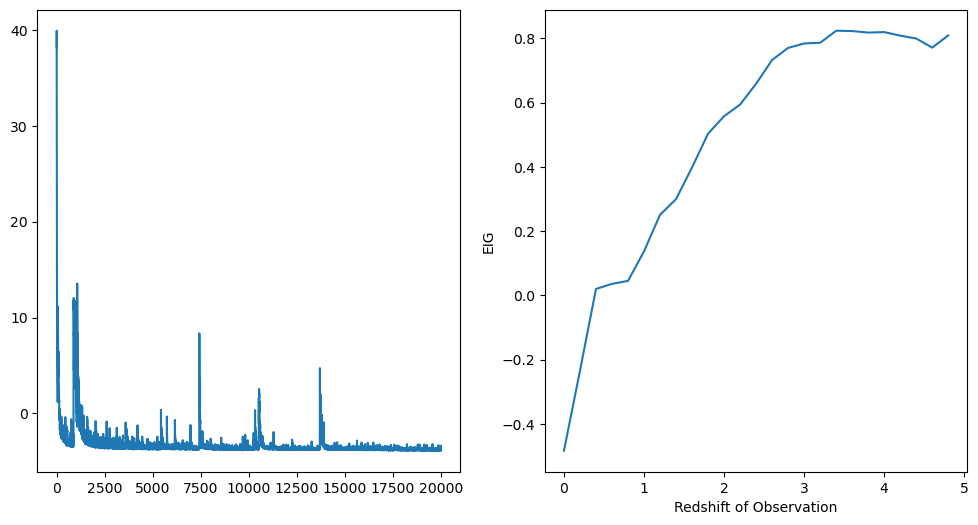

In [45]:
Om_range = torch.tensor([0.2, 0.4], device=device)
Ode_range = torch.tensor([0.6, 0.8], device=device)
w0_range = torch.tensor(-3, 1, device=device)
wa_range = torch.tensor(-3, 2, device=device)
cosmologies = ['LambdaCDM', 'FlatLambdaCDM', 'w0waCDM']
for c in cosmologies:
    if c == 'LambdaCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range), 'Orad': torch.tensor(0.00149, device=device)}
        bed_cosmo = bed_cosmology(
            cosmo=LambdaCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, Neff=Planck18.Neff, m_nu=Planck18.m_nu, name='LambdaCDM'), 
            priors=priors, 
            sigma_y=0.1)
    elif c == 'FlatLambdaCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range)}
        bed_cosmo = bed_cosmology(
            cosmo=FlatLambdaCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, name='FlatLambdaCDM'), 
            priors=priors, 
            sigma_y=0.1)
    elif c == 'w0waCDM':
        priors = {'Om': dist.Uniform(*Om_range), 'Ode': dist.Uniform(*Ode_range), 'Orad': torch.tensor(0.00149, device=device), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}
        bed_cosmo = bed_cosmology(
            cosmo=w0waCDM(H0=Planck18.H0, Om0=Planck18.Om0, Tcmb0=Planck18.Tcmb0, Ode0=Planck18.Ode0, Neff=Planck18.Neff, m_nu=Planck18.m_nu, name='w0waCDM'), 
            priors=priors, 
            sigma_y=0.1)
    target_labels = priors.keys()
    train_args = {"observation_labels": ["y"],
                "target_labels": ,
                "model": bed_cosmo.pyro_model,
                "steps": 20000,
                "n_particles": 101,
                "train_verbose": False, 
                "condition_design": True,
                "device": device}

    pyro.clear_param_store()
    segments = 15
    n_transforms = 15
    input_dim = 2
    context_dim = 2
    learning_rate = 1e-3
    posterior_flow, transforms = pyro_flows.spline_flow(n_transforms, input_dim, context_dim, segments, device)
    modules = torch.nn.ModuleList(transforms)
    optimizer = torch.optim.AdamW(modules.parameters(), lr=learning_rate, weight_decay=1e-3)

    #posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)
    #optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-4)
    device = train_args["device"]
    #posterior_flow.to(device)
    #posterior_flow.train(mode=True)
    pyro.set_rng_seed(0)

    history = []
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    for step in range(train_args["steps"]):
        optimizer.zero_grad()
        agg_loss, loss = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=train_args["n_particles"],
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=False,
                                        nflow=True,
                                        condition_design=train_args["condition_design"],
                                        verbose_shapes=False)
        agg_loss.backward()
        optimizer.step()
        if step == 0:
            verbose_shapes = False

        history.append(loss)
        if train_args["train_verbose"] and (step % 250 == 0):
            print('step: {}, loss: {}'.format(step, agg_loss.item()))

    stacked_history = torch.stack(history)
    history_array = stacked_history.cpu().detach().numpy()
    #ax1.plot(history_array.sum(axis=1)/history_array.shape[-1])

    with torch.no_grad():
        agg_loss, eigs = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=50000,
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=True,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])

    plt.plot(redshifts, eigs.cpu().detach().numpy(), label=c)
    plt.set_xlabel("Redshift of Observation")
    plt.set_ylabel("EIG")
plt.show()

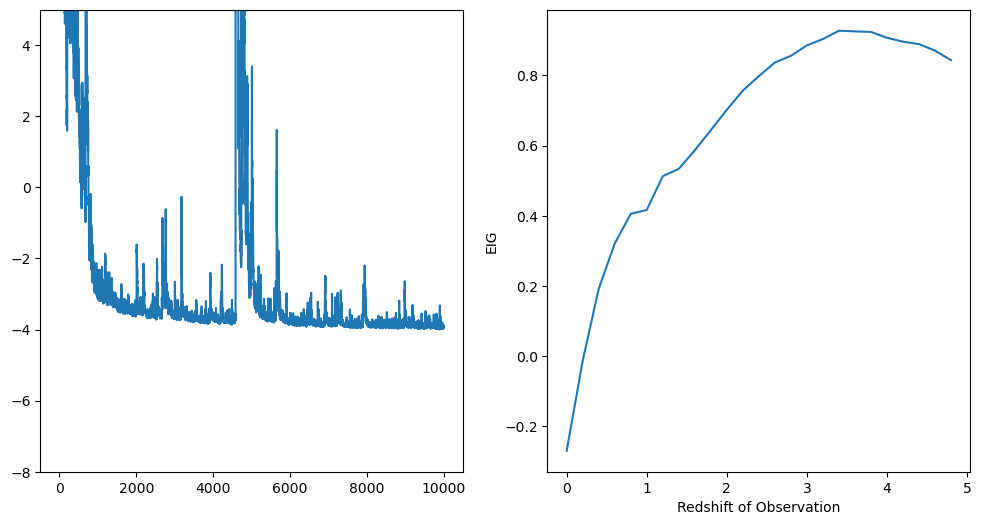

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_array.sum(axis=1)/history_array.shape[-1])
ax1.set_ylim(-8, 5)

with torch.no_grad():
    agg_loss, eigs = posterior_loss(design=designs,
                                    model=train_args["model"],
                                    guide = posterior_flow,
                                    num_particles=50000,
                                    observation_labels=train_args["observation_labels"],
                                    target_labels=train_args["target_labels"],
                                    evaluation=True,
                                    nflow=True,
                                    condition_design=train_args["condition_design"])

ax2.plot(redshifts, eigs.cpu().detach().numpy())
ax2.set_xlabel("Redshift of Observation")
ax2.set_ylabel("EIG")
plt.show()

In [25]:
history_array

array([[84.03527019, 77.89221185, 70.31883617, ..., 21.54920315,
        22.40937439, 23.0897492 ],
       [80.72509366, 78.05562778, 75.93284783, ..., 30.05386049,
        27.86990599, 27.30720184],
       [73.66719589, 72.27436033, 71.38488241, ..., 25.64523125,
        24.73761496, 23.88006598],
       ...,
       [-2.74408825, -3.0393109 , -3.24204999, ..., -3.66143765,
        -3.53150509, -3.93074333],
       [-2.67703389, -3.04454933, -3.08971687, ..., -3.71945653,
        -3.54191245, -3.75468436],
       [-2.75831308, -2.87364493, -3.09377445, ..., -3.88742404,
        -3.69036581, -3.73389418]])

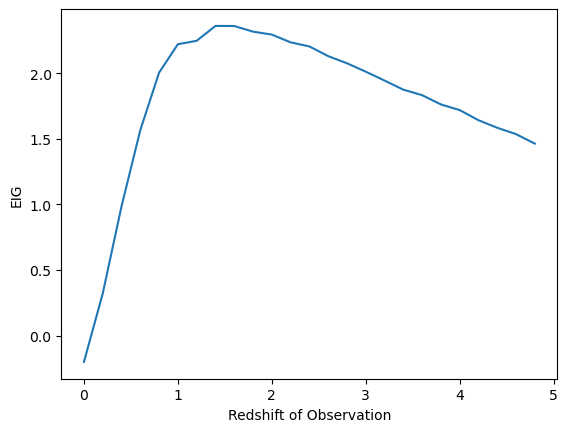

In [17]:
plt.plot(redshifts, eigs.cpu().detach().numpy()/np.log(2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.show()

In [ ]:
plt.plot(redshifts, eigs.cpu().detach().numpy())
plt.xticks(np.round(redshifts, 2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.show()

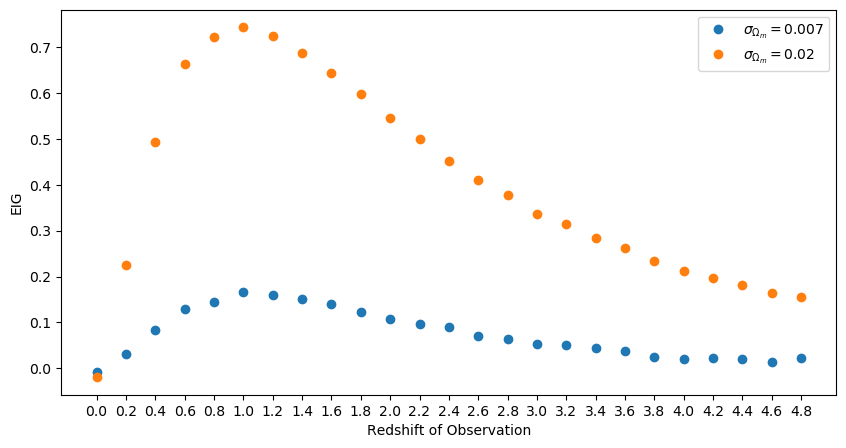

In [10]:
train_args = {"observation_labels": ["y"],
            "target_labels": ["Om", "Ode"],
            "model": bed_cosmo.pyro_model,
            "steps": 20000,
            "n_particles": 101,
            "train_verbose": False, 
            "condition_design": True,
            "device": device}
plt.figure(figsize=(10,5))
for i in [0.007, 0.02]:
    om_prior = torch.tensor(0.315, device=device) # Gaussian prior mean
    sigma_prior = torch.tensor(i, device=device) # Gaussian prior std
    sig_0 = torch.tensor(0.2, device=device) # Gaussian likelihood std

    def model(z):
        with pyro.plate_stack("plate", z.shape[:-1]):
            om = pyro.sample("om", dist.Normal(om_prior,sigma_prior)).unsqueeze(-1) # shape: [n,num_designs,1]
            mean = model_func(om, z)
            return pyro.sample("y", dist.Normal(mean, sig_0).to_event(1))

    posterior_flow = flows.conditional_affine_autoregressive(num_transforms, flow_args=flow_args)

    pyro.clear_param_store()
    optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=5e-4)
    device = train_args["device"]
    posterior_flow.to(device)
    posterior_flow.train(mode=True)
    pyro.set_rng_seed(0)

    history = []

    for step in range(train_args["steps"]):
        optimizer.zero_grad()
        agg_loss, loss = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=train_args["n_particles"],
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=False,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])
        agg_loss.backward()
        optimizer.step()
        if step == 0:
            verbose_shapes = False

        history.append(loss)
        if train_args["train_verbose"] and (step % 250 == 0):
            print('step: {}, loss: {}'.format(step, agg_loss.item()))

    stacked_history = torch.stack(history)
    history_array = stacked_history.cpu().detach().numpy()

    with torch.no_grad():
        agg_loss, eigs = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=50000,
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=True,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])

    plt.plot(redshifts, eigs.cpu().detach().numpy(), 'o', label=r"$\sigma_{\Omega_m}=$"+f"{i}")

plt.xticks(np.round(redshifts, 2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.legend()
plt.show()

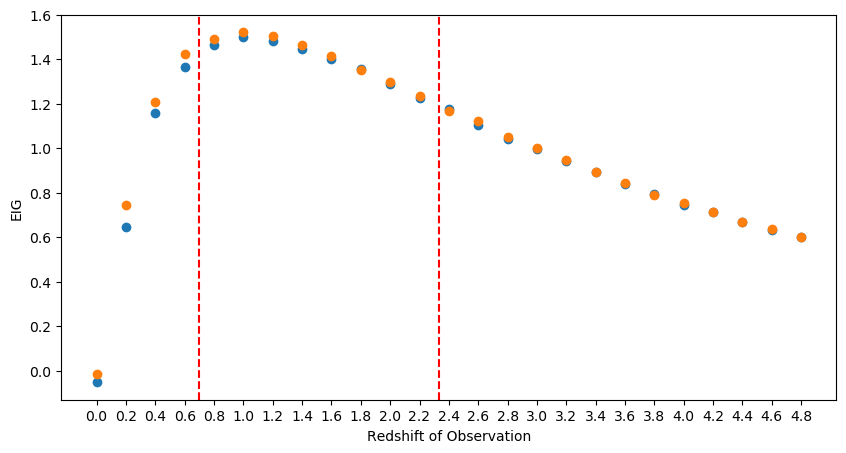

In [96]:
plt.figure(figsize=(10,5))
plt.plot(redshifts, eigs.cpu().detach().numpy(), 'o')
plt.plot(redshifts, eigs_uni.cpu().detach().numpy(), 'o')
# plot vertical line of the previous measurements
plt.axvline(x=0.698, color='r', linestyle='--')
plt.axvline(x=2.330, color='r', linestyle='--')
plt.xticks(np.round(redshifts, 2))
plt.xlabel("Redshift of Observation")
plt.ylabel("EIG")
plt.show()

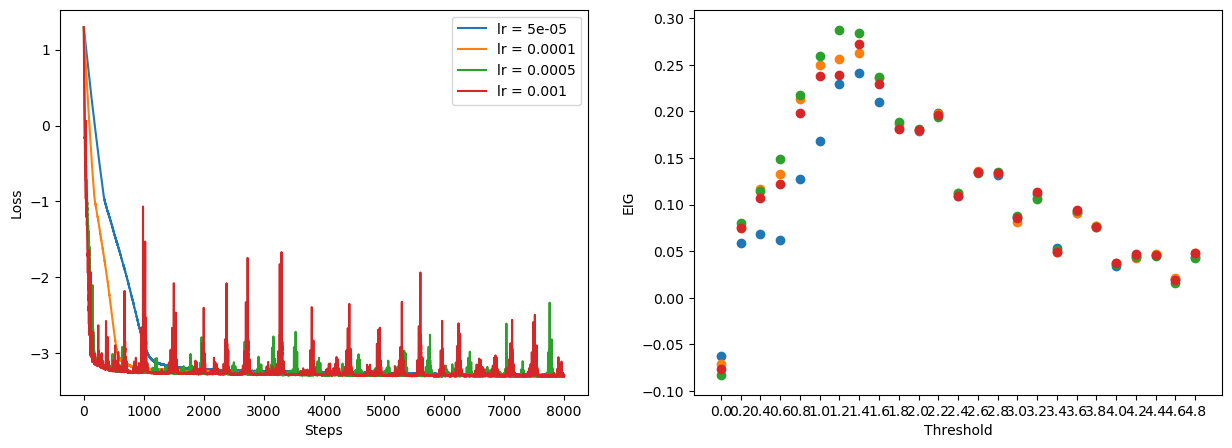

In [103]:
train_args = {"observation_labels": ["y"],
            "target_labels": ["om"],
            "model": model,
            "steps": 8000,
            "n_particles": 2001,
            "train_verbose": False, 
            "condition_design": True,
            "device": device}

# training with different learning rates and plotting the results:
lrs = [5e-5, 1e-4, 5e-4, 1e-3]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in lrs:
    pyro.clear_param_store()
    posterior_flow = flows.conditional_affine_autoregressive(num_transforms,
                                                   flow_args=flow_args)

    optimizer = torch.optim.AdamW(posterior_flow.parameters(), lr=i) # AdamW: Adam optimizer with weight decay regularization to penalize large weights
    device = train_args["device"]
    posterior_flow.to(device)
    posterior_flow.train(mode=True)
    observation_labels = train_args["observation_labels"]
    target_labels = train_args["target_labels"]
    pyro.set_rng_seed(0)

    history = []
    verbose_shapes = False
    for step in range(train_args["steps"]):
        optimizer.zero_grad()
        agg_loss, loss = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=train_args["n_particles"],
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=False,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])
        agg_loss.backward()
        optimizer.step()
        if step == 0:
            verbose_shapes = False

        history.append(loss)
        if train_args["train_verbose"] and (step % 250 == 0):
            print('step: {}, loss: {}'.format(step, agg_loss.item()))


    stacked_history = torch.stack(history)
    history_array = stacked_history.cpu().detach().numpy()
    ax1.plot(history_array.sum(axis=1)/history_array.shape[-1], label="lr = {}".format(i))

    with torch.no_grad():
        agg_loss, eigs = posterior_loss(design=designs,
                                        model=train_args["model"],
                                        guide = posterior_flow,
                                        num_particles=1000,
                                        observation_labels=train_args["observation_labels"],
                                        target_labels=train_args["target_labels"],
                                        evaluation=True,
                                        nflow=True,
                                        condition_design=train_args["condition_design"])
    ax2.scatter(redshifts, eigs.cpu().numpy(), marker='o')

ax2.set_xticks(np.round(redshifts, 2))
ax2.set_xlabel("Threshold")
ax2.set_ylabel("EIG")

ax1.legend()
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
plt.show()